# Subsurface temperature maximum depth for ACCESS-OM2

In [11]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe
import gsw

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/42103/status,
Dashboard: /proxy/42103/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37047,Workers: 0
Dashboard: /proxy/42103/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:46351,Total threads: 1
Dashboard: /proxy/44655/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:36501,


In [4]:
# Importing data
pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/*/*.ocean_month_z.nc'))
pathsM = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/*/*.ocean_month_z.nc'))

In [5]:
# Creating shelf mask

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [6]:
depth = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho']
land_mask = (0 * depth).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6_01')
land = xr.where(np.isnan(depth.rename('land')), 1, np.nan)

In [8]:
#Time variant variables
def preprocess(ds):
    ds = ds[['so','thetao']].sel(yh=slice(None,-39))
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [20]:
# Time slicing of last 5 years for map
cont = cont.sel(time=slice('2006-01-01','2010-12-31'))
melt = melt.sel(time=slice('2006-01-01','2010-12-31'))

In [21]:
# Calculating pressure
p_cont = gsw.p_from_z(-cont['z_l'], cont['yh'])
p_melt = gsw.p_from_z(-melt['z_l'], melt['yh'])

# Calculating absolute salinity
SA_cont = gsw.SA_from_SP(cont['so'], p_cont, cont['xh'], cont['yh'])
SA_melt =  gsw.SA_from_SP(melt['so'], p_melt, melt['xh'], melt['yh'])

# Calculating conservative temperature
tempC = gsw.CT_from_pt(SA_cont,cont['thetao'])
tempM = gsw.CT_from_pt(SA_melt,melt['thetao'])

In [22]:
tempC

<xarray.DataArray 'so' (time: 60, z_l: 75, yh: 821, xh: 3600)> Size: 106GB
dask.array<ct_from_pt, shape=(60, 75, 821, 3600), dtype=float64, chunksize=(2, 22, 242, 1030), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 7kB -81.11 -81.07 -81.02 ... -39.18 -39.1 -39.03
  * z_l      (z_l) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time     (time) object 480B 2006-01-16 12:00:00 ... 2010-12-16 12:00:00
Attributes:
    units:          psu
    long_name:      Sea Water Salinity
    cell_methods:   area:mean z_l:mean yh:mean xh:mean time: mean
    cell_measures:  volume: volcello area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_salinity

In [23]:
# Mask surface layers (<50m)
temp_sub_C = tempC.sel(z_l=slice(50,None))
temp_sub_M = tempM.sel(z_l=slice(50,None))
temp_sub_C

<xarray.DataArray 'so' (time: 60, z_l: 57, yh: 821, xh: 3600)> Size: 81GB
dask.array<getitem, shape=(60, 57, 821, 3600), dtype=float64, chunksize=(2, 22, 242, 1030), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 7kB -81.11 -81.07 -81.02 ... -39.18 -39.1 -39.03
  * z_l      (z_l) float64 456B 55.21 62.09 69.69 ... 5.511e+03 5.709e+03
  * time     (time) object 480B 2006-01-16 12:00:00 ... 2010-12-16 12:00:00
Attributes:
    units:          psu
    long_name:      Sea Water Salinity
    cell_methods:   area:mean z_l:mean yh:mean xh:mean time: mean
    cell_measures:  volume: volcello area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_salinity

In [24]:
# Depth of subsurface temperature maximum (pulls out maximum temp in each water column)
stm_depth_C = temp_sub_C.idxmax(dim='z_l')
stm_depth_M = temp_sub_M.idxmax(dim='z_l')
stm_depth_C

<xarray.DataArray 'z_l' (time: 60, yh: 821, xh: 3600)> Size: 1GB
dask.array<where, shape=(60, 821, 3600), dtype=float64, chunksize=(2, 242, 1030), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 7kB -81.11 -81.07 -81.02 ... -39.18 -39.1 -39.03
  * time     (time) object 480B 2006-01-16 12:00:00 ... 2010-12-16 12:00:00

### Plotting

In [25]:
# Take time mean
stm_depth_C_map = stm_depth_C.mean(dim='time')
stm_depth_M_map = stm_depth_M.mean(dim='time')
stm_depth_C_map

<xarray.DataArray 'z_l' (yh: 821, xh: 3600)> Size: 24MB
dask.array<mean_agg-aggregate, shape=(821, 3600), dtype=float64, chunksize=(242, 1030), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 7kB -81.11 -81.07 -81.02 ... -39.18 -39.1 -39.03

In [26]:
# Anomaly (Melt - Control)
stm_depth_anom_map = stm_depth_M_map - stm_depth_C_map
stm_depth_anom_map

<xarray.DataArray 'z_l' (yh: 821, xh: 3600)> Size: 24MB
dask.array<sub, shape=(821, 3600), dtype=float64, chunksize=(242, 1030), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 7kB -81.11 -81.07 -81.02 ... -39.18 -39.1 -39.03

In [27]:
stm_depth_anom_map.load()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/dask/array/reductions.py:783: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/dask/array/reductions.py:783: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/dask/array/reductions.py:783: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/dask/array/reductions.py:783: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/dask/array/reductions.py:783: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_a

<xarray.DataArray 'z_l' (yh: 821, xh: 3600)> Size: 24MB
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [-2.63854112, -4.11350942, -3.85896919, ...,  0.        ,
         0.        , -2.63854112],
       [-4.11350942, -3.85896919, -3.50281333, ...,  0.        ,
         0.        ,  0.        ],
       [-1.58967387, -1.33513363,  0.2414503 , ...,  0.        ,
         0.11470556,  0.11470556]])
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 7kB -81.11 -81.07 -81.02 ... -39.18 -39.1 -39.03

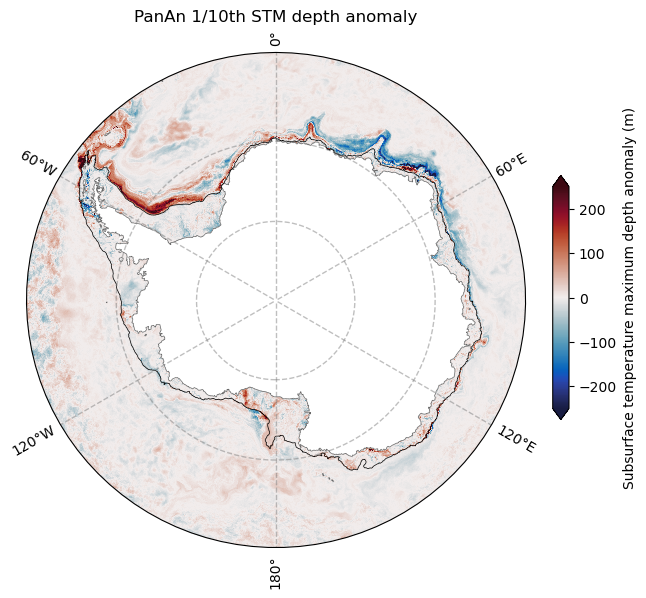

In [29]:
projection = ccrs.SouthPolarStereo()
    
plt.figure(figsize=(7, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
    
# Circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='white',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Coast line
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
# Shelf contour
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.5,transform = ccrs.PlateCarree())

# Adding polar axes
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                    xlocs=range(-180,171,60), ylocs=[], 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, 
                    xlocs=[], ylocs=(-80,-70,-55), 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)

# Plotting
stm_depth_anom_map.plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    vmin=-250,
    vmax=250,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Subsurface temperature maximum depth anomaly (m)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("PanAn 1/10th STM depth anomaly");